<a href="https://colab.research.google.com/github/kanishk16/hgRecog/blob/master/handy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# neccessary imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow as cv_imshow

# version check
cv.__version__

'3.4.3'

In [0]:
## Creating a function to download img from a url specified by the USER
import urllib.request as urlrequest

def dl_img(url, file_path, file_name):
  _path = file_path + file_name + '.jpg'
  urlrequest.urlretrieve(url, _path)
  
url = input("URL: ")
saveas = input("File Name: ")

dl_img(url, '/content/', saveas)

# https://cdn.shopify.com/s/files/1/1893/0477/products/5PCS_Framed_Colorful_Lion_Canvas_Prints_grande.png?v=1504331897
# https://www.artgalleryofhamilton.com/wp-content/uploads/2018/04/abstract-painting.jpg
# https://pythonprogramming.net/static/images/opencv/bookpage.jpg
# https://matplotlib.org/3.1.1/_images/sphx_glr_scatter_piecharts_thumb.png
# https://matplotlib.org/3.1.1/_images/sphx_glr_scatter_001.png
# https://matplotlib.org/3.1.1/_images/sphx_glr_scatter3d_001.png
# https://www.mathworks.com/help/examples/matlabmobile/win64/Scatter3DPlotExample_01.png
# https://github.com/vishwajeetsinghrana8/OpenCV/blob/master/Hand_Gesture/Capture.png?raw=true

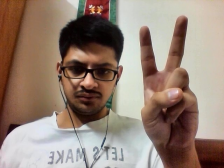

In [0]:
# load an img
# img1 = cv.imread('hand_ges.jpg', 1)
img1 = cv.imread('hand-2.JPG', 1)

# resizing imgs. to same size & display the img.
imgr1 = cv.resize(img1, None, None, 0.35, 0.35, interpolation = cv.INTER_AREA)
# imgr2 = cv.resize(img2, None, None, 0.35, 0.35, interpolation = cv.INTER_AREA)

cv_imshow(imgr1)
# cv_imshow(imgr2)


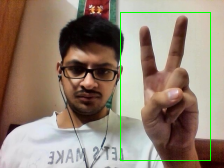

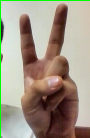

In [0]:
# create a window
window_imgr1 = cv.rectangle(imgr1.copy(), (120,12), (210,160), (0,255,0))
cv_imshow(window_imgr1)

# extract hand from the sub-window: crop_img = img[h1:h2, w1:w2]
crop_imgr1 = window_imgr1[12:150, 120:210]
cv_imshow(crop_imgr1)

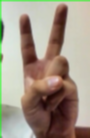

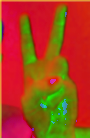

In [0]:
# blur
blur_imgr1 = cv.GaussianBlur(crop_imgr1, (3,3), 0)
cv_imshow(blur_imgr1)

# converting it to hsv
hsv_imgr1 = cv.cvtColor(blur_imgr1, cv.COLOR_BGR2HSV)
cv_imshow(hsv_imgr1)

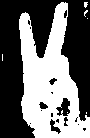

In [0]:
# define the lower n upper bound for color
lower_skin = np.array([2,0,0])
upper_skin = np.array([15,255,255])

# checks if arg_2 < img.(arg_1)elements < arg_3 and sets each of them in the range to 1 rest to 0   
mask = cv.inRange(hsv_imgr1, lower_skin, upper_skin)
cv_imshow(mask)

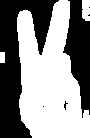

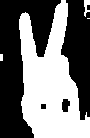

In [0]:
# morphological transformation
kernel = np.ones((5,5), np.uint8)

# dilation - px 0/1 1:atleast one px under the kernel is 1
dilation_imgr1 = cv.dilate(mask, kernel, iterations = 1)
cv_imshow(dilation_imgr1)

# erosion - px 0/1 1:all the px under the kernel are 1
erosion_imgr1 = cv.erode(dilation_imgr1, kernel, iterations = 1)
cv_imshow(erosion_imgr1)

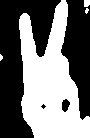

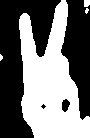

In [0]:
# median filtering
median_imgr1 = cv.medianBlur(erosion_imgr1, 5)
cv_imshow(median_imgr1)

# thresholding
retval, threshold = cv.threshold(median_imgr1, 70, 255, cv.THRESH_BINARY)
cv_imshow(threshold)

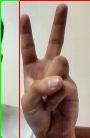

In [0]:
# find contours
_, contours, _ = cv.findContours(threshold, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# find contour with max. area
contour = max(contours, key = lambda x: cv.contourArea(x))

# creating a bounding rectangle around the contour
x, y, w, h = cv.boundingRect(contour)
crec_imgr1 = cv.rectangle(crop_imgr1, (x,y), (x+w,y+h), (0,0,255))
cv_imshow(crec_imgr1)

[[[ 89 137]]

 [[ 34 137]]

 [[ 24 119]]

 [[ 23 117]]

 [[ 22 112]]

 [[ 21 105]]

 [[ 19  29]]

 [[ 19  19]]

 [[ 20  16]]

 [[ 23  13]]

 [[ 61   0]]

 [[ 65   0]]

 [[ 67   4]]

 [[ 89 117]]]


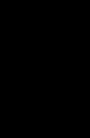

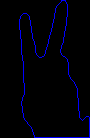

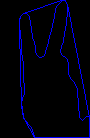

In [0]:
# find convex hull for drawing the contour
hull = cv.convexHull(contour)
print(hull)

# draw the contour on a black background
draw = np.zeros(crop_imgr1.shape, np.uint8)
cv_imshow(draw)

contour_imgr1 = cv.drawContours(draw, [contour], -1, (255,0,0), 0)
cv_imshow(contour_imgr1)

hull_imgr1 = cv.drawContours(draw, [hull], -1, (255,0,0), 0)
cv_imshow(contour_imgr1)

In [0]:
# find convexity defects
defect_hull = cv.convexHull(contour, returnPoints = False)

defects = cv.convexityDefects(contour, defect_hull)
print(defects)

[[[   87   130   115  4107]]

 [[  130   134   131   114]]

 [[    0    49    30 12149]]

 [[   50    52    51   162]]

 [[   53    69    62   916]]

 [[   69    71    70   217]]

 [[   71    73    72   201]]

 [[   73    75    74   114]]

 [[   75    85    78   572]]]


In [0]:
import math

# cosine rule to find angle of the far point from the start n end point i.e. 
# the convex points (the finger tips) for all defects
count_defects = 0

for i in range(defects.shape[0]):
  s, e, f, d = defects[i,0]
  start = tuple(contour[s][0])
  end = tuple(contour[e][0])
  far = tuple(contour[f][0])

  a = math.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
  b = math.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
  c = math.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
  angle = (math.acos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c)) * 180) / 3.14


  # if angle > 90 draw a circle at the far point
  if angle <= 90:
    count_defects += 1
    cv.circle(crop_imgr1, far, 1, [0, 0, 255], -1)

  cv.line(crop_imgr1, start, end, [0, 255, 0], 2)

print('defects:',count_defects)  

defects: 1


In [0]:
# Mounting Google  Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [6]:
# necessary imports
import os

# setup kaggle API
os.environ['KAGGLE_USERNAME'] = "kanishk10"
os.environ['KAGGLE_KEY'] = "44a2ea449c145487d3a4e8f3d501b6a3"

!kaggle datasets download -d koryakinp/fingers 

 99% 358M/363M [00:02<00:00, 182MB/s]
100% 363M/363M [00:02<00:00, 163MB/s]


In [0]:
#unzip a file to a path -d(destination)
!unzip fingers.zip -d /content

In [0]:
# count the num of files in a dir (w/o recursively)
!ls fingers/train/0L -F |grep -v / | wc -l

0


In [8]:
# Colab pillow_version:4.3.0 Reqd.:pillow_version: 5.3.0

# Uninstall the Old version
!pip uninstall -y Pillow

# Install the new one
!pip install Pillow==5.3.0

# import the new one
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-4.3.0:
  Successfully uninstalled Pillow-4.3.0
     |████████████████████████████████| 2.0MB 6.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


4.3.0


In [0]:
# necessary imports
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU ...')
else:
  print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


In [4]:
import os 
# source_path = '/content/check-1'

def file_to_dir(src_path):
  # iterating through all the files
  for filename in os.listdir(src_path):
    # extracting the name from the file
    _dir_name = filename.split('_')[1].split('.')[0]
    dir_name = src_path + '/' + _dir_name
    
    # current path (+file)
    src_path_file = src_path + '/' + filename
    
    # destination path (+file)
    dst_path_file = dir_name + '/' + filename

    if os.path.isdir(dir_name):
      # move the img to the dir
      os.replace(src_path_file, dst_path_file)
    else:
      # create a dir if doesn't exist
      os.mkdir(dir_name)
      # move the file to the dir
      os.replace(src_path_file, dst_path_file)

src_path = input("PATH to DIR:") 
file_to_dir(src_path)     

PATH to DIR:/content/fingers/test


In [0]:
# specify path
train_dir = '/content/fingers/train'
test_dir = '/content/fingers/test'

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([transforms.Resize(225),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load the training and test datasets using Imagefolder
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))

# shuffle indices along the first axis (order of sub-arrays is changed but their contents remain the same) 
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler to return an iterable)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# specify the image classes
classes = ['0L', '0R', '1L', '1R', '2L', '2R','3L', '3R', '4L', '4R', '5L', '5R']


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  # unnormalize
  img = img / 2 + 0.5  
  # convert from Tensor image
  plt.imshow(np.transpose(img, (1, 2, 0)))

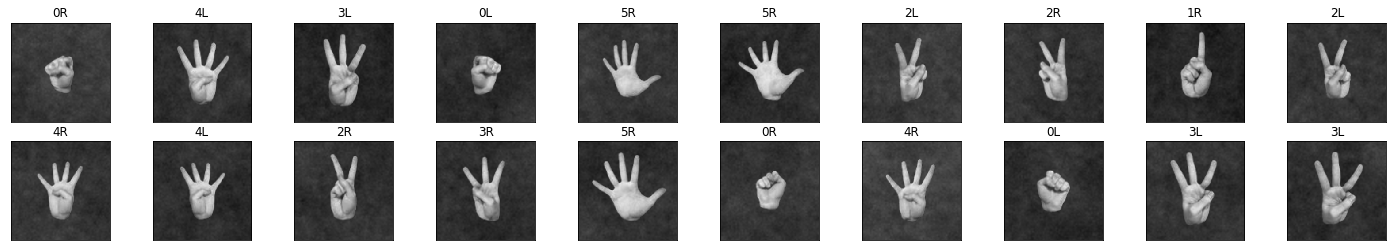

In [14]:
# obtain a batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# convert images to numpy for display
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])
